In [1]:
import os
import tensorflow as tf
# GPU 메모리 사용 점진적 할당 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
# 설정 변수
epochs = 20
batch_size = 32
validation_split = 0.2

In [35]:
import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# 파일 경로 설정
train_file_path = 'data/mnt/train.csv'
export_path = 'data/'
train_data = pd.read_csv(train_file_path)

# 텍스트 정제 함수
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # 다중 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수 문자 제거
    return text.strip()

train_data['cleaned_conversation'] = train_data['conversation'].apply(clean_text)
train_data['text_length'] = train_data['cleaned_conversation'].apply(len)

# 토크나이저 설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_conversation'])

# 시퀀스 변환 및 패딩
sequences = tokenizer.texts_to_sequences(train_data['cleaned_conversation'])
max_length = 300
X_data = pad_sequences(sequences, maxlen=max_length, padding='post')

# 레이블 인코딩
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(train_data['class'])

# 결과 확인
print('토크나이저 단어 개수:', len(tokenizer.word_index))
print('X_data 크기:', X_data.shape)
print('y_data 크기:', y_data.shape)

토크나이저 단어 개수: 52568
X_data 크기: (3950, 300)
y_data 크기: (3950,)


In [4]:
# 전처리된 데이터 저장
# np.save(export_path + 'X_data.npy', X_data)
# np.save(export_path + 'y_data.npy', y_data)

# 데이터 로드
# padded_sequences = np.load('data/X_data.npy')
#labels = np.load('data/y_data.npy')
padded_sequences = X_data
labels = y_data

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

# 입력 정의
input_layer = Input(shape=(max_length,), name='input')

# 임베딩 층
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)

# LSTM 층
lstm_layer = LSTM(64)(embedding_layer)

# 출력층 정의
num_classes = 4
output_layer = Dense(num_classes, activation='softmax', name='output')(lstm_layer)

# 모델 생성
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          6728832   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
output (Dense)               (None, 4)                 260       
Total params: 6,778,500
Trainable params: 6,778,500
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 모델 학습
history = model.fit(
    padded_sequences, labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split
)

Epoch 1/20
99/99 [==============================] - 5s 19ms/step - loss: 1.3855 - accuracy: 0.2734 - val_loss: 1.3918 - val_accuracy: 0.2494
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3841 - accuracy: 0.2839 - val_loss: 1.3934 - val_accuracy: 0.2494
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3833 - accuracy: 0.2839 - val_loss: 1.3909 - val_accuracy: 0.2494
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3830 - accuracy: 0.2839 - val_loss: 1.3903 - val_accuracy: 0.2494
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3832 - accuracy: 0.2839 - val_loss: 1.3909 - val_accuracy: 0.2494
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3835 - accuracy: 0.2839 - val_loss: 1.3918 - val_accuracy: 0.2494
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3829 - accuracy: 0.2839 - val_loss: 1.3890 - val_accuracy: 0.2494
Epoch 8/20
99

# 1. CNN 구조를 엮은 모델

In [7]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense

input_layer = Input(shape=(max_length,), name='input')

embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)

conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
polling_layer = GlobalMaxPooling1D()(conv_layer)

output_layer = Dense(num_classes, activation='softmax', name='output')(polling_layer)

model_conv = Model(inputs=input_layer, outputs=output_layer)
model_conv.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_conv.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 300, 128)          6728832   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 4)                 516       
Total params: 6,811,396
Trainable params: 6,811,396
Non-trainable params: 0
_________________________________________________________________


In [8]:
con_history = model.fit(
    padded_sequences,
    labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split
)

Epoch 1/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3824 - accuracy: 0.2839 - val_loss: 1.3913 - val_accuracy: 0.2494
Epoch 2/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3827 - accuracy: 0.2839 - val_loss: 1.3911 - val_accuracy: 0.2494
Epoch 3/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3827 - accuracy: 0.2839 - val_loss: 1.3911 - val_accuracy: 0.2494
Epoch 4/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3826 - accuracy: 0.2839 - val_loss: 1.3906 - val_accuracy: 0.2494
Epoch 5/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3825 - accuracy: 0.2839 - val_loss: 1.3904 - val_accuracy: 0.2494
Epoch 6/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3825 - accuracy: 0.2839 - val_loss: 1.3937 - val_accuracy: 0.2494
Epoch 7/20
99/99 [==============================] - 1s 14ms/step - loss: 1.3821 - accuracy: 0.2839 - val_loss: 1.3888 - val_accuracy: 0.2494
Epoch 8/20
99

# Bidirectional LSTM

In [9]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense

# 입력 정의
input_layer = Input(shape=(max_length,), name='input')

# 임베딩 층
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(input_layer)

# 양방향 LSTM 층
bi_lstm_layer = Bidirectional(LSTM(64))(embedding_layer)

# 출력층 정의
output_layer = Dense(num_classes, activation='softmax', name='output')(bi_lstm_layer)

# 모델 생성
model_bi = Model(inputs=input_layer, outputs=output_layer)

# 모델 컴파일
model_bi.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model_bi.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 300)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 300, 128)          6728832   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
output (Dense)               (None, 4)                 516       
Total params: 6,828,164
Trainable params: 6,828,164
Non-trainable params: 0
_________________________________________________________________


In [10]:
model_bi_history = model_bi.fit(
    padded_sequences,
    labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split
)

Epoch 1/20
99/99 [==============================] - 5s 30ms/step - loss: 1.1302 - accuracy: 0.5013 - val_loss: 0.7861 - val_accuracy: 0.7000
Epoch 2/20
99/99 [==============================] - 2s 23ms/step - loss: 0.3236 - accuracy: 0.9063 - val_loss: 0.5435 - val_accuracy: 0.8051
Epoch 3/20
99/99 [==============================] - 2s 23ms/step - loss: 0.0743 - accuracy: 0.9832 - val_loss: 0.5290 - val_accuracy: 0.8076
Epoch 4/20
99/99 [==============================] - 2s 23ms/step - loss: 0.0192 - accuracy: 0.9968 - val_loss: 0.6654 - val_accuracy: 0.7848
Epoch 5/20
99/99 [==============================] - 2s 23ms/step - loss: 0.0089 - accuracy: 0.9984 - val_loss: 0.7097 - val_accuracy: 0.8038
Epoch 6/20
99/99 [==============================] - 2s 23ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.7205 - val_accuracy: 0.8177
Epoch 7/20
99/99 [==============================] - 2s 23ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.7723 - val_accuracy: 0.8038
Epoch 8/20
99

# BERT 모델

In [11]:
"""
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D

bert_model_name = 'distilbert-base-uncased'

# BERT 모델 로드
bert_model = TFBertModel.from_pretrained(bert_model_name)

# BERT 토크나이저
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# 입력 정의
input_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

# BERT 모델 레이어
bert_output = bert_model([input_ids, attention_mask])[0]

pooling_layer = GlobalAveragePooling1D()(bert_output)

# 출력층 정의
output_layer = Dense(num_classes, activation='softmax', name='output')(pooling_layer)

# 모델 생성
model_bert = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# 모델 컴파일
model_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model_bert.summary()
"""

"\nfrom transformers import BertTokenizer, TFBertModel\nfrom tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D\n\nbert_model_name = 'distilbert-base-uncased'\n\n# BERT 모델 로드\nbert_model = TFBertModel.from_pretrained(bert_model_name)\n\n# BERT 토크나이저\ntokenizer = BertTokenizer.from_pretrained(bert_model_name)\n\n# 입력 정의\ninput_ids = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')\nattention_mask = Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')\n\n# BERT 모델 레이어\nbert_output = bert_model([input_ids, attention_mask])[0]\n\npooling_layer = GlobalAveragePooling1D()(bert_output)\n\n# 출력층 정의\noutput_layer = Dense(num_classes, activation='softmax', name='output')(pooling_layer)\n\n# 모델 생성\nmodel_bert = Model(inputs=[input_ids, attention_mask], outputs=output_layer)\n\n# 모델 컴파일\nmodel_bert.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])\n\n# 모델 요약\nmodel_bert.summary()\n"

In [12]:
"""
# BERT 입력 데이터 생성
def encode_textx(texts, max_length):
    inputs = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'], inputs['attention_mask']

texts = train_data['cleaned_conversation'].tolist()
input_ids, attention_mask = encode_textx(texts, max_length)

# 모델 학습
history_bert = model_bert.fit(
    [input_ids, attention_mask],
    labels,
    epochs=epochs,
    batch_size=8,
    validation_split=validation_split
)
"""

"\n# BERT 입력 데이터 생성\ndef encode_textx(texts, max_length):\n    inputs = tokenizer(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')\n    return inputs['input_ids'], inputs['attention_mask']\n\ntexts = train_data['cleaned_conversation'].tolist()\ninput_ids, attention_mask = encode_textx(texts, max_length)\n\n# 모델 학습\nhistory_bert = model_bert.fit(\n    [input_ids, attention_mask],\n    labels,\n    epochs=epochs,\n    batch_size=8,\n    validation_split=validation_split\n)\n"

# 사전 학습 모델

In [22]:
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

# DistilBERT 모델과 토크나이저 설정
distilbert_model_name = 'distilbert-base-multilingual-cased'
distilbert_model = TFDistilBertModel.from_pretrained(distilbert_model_name)
tokenizer_dis = DistilBertTokenizer.from_pretrained(distilbert_model_name)

# 최대 시퀀스 길이 설정
max_length = 128

# 데이터 전처리 함수
def encode_texts(texts, max_length=128):
    inputs = tokenizer_dis(texts, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')
    return inputs['input_ids'], inputs['attention_mask']

# 데이터 로드 및 전처리
texts = train_data['cleaned_conversation'].tolist()
input_ids, attention_masks = encode_texts(texts, max_length)

# Tensor 변환
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()

# 입력 정의
input_ids_train, input_ids_val, attention_masks_train, attention_masks_val, targets_train, targets_val = train_test_split(
    input_ids, attention_masks, labels, test_size=validation_split, random_state=42)

# TensorFlow Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices(((input_ids_train, attention_masks_train), targets_train)).shuffle(len(input_ids_train)).batch(4)
val_dataset = tf.data.Dataset.from_tensor_slices(((input_ids_val, attention_masks_val), targets_val)).batch(4)

# 모델 정의 함수
def create_model(num_classes):
    input_ids_input = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks_input = Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
    distilbert_output = distilbert_model([input_ids_input, attention_masks_input])[0][:, 0, :]
    output_layer = Dense(num_classes, activation='softmax')(distilbert_output)
    model = Model(inputs=[input_ids_input, attention_masks_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model_bert = create_model(num_classes)

# 모델 요약
model_bert.summary()

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_masks (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_6 (TFDisti TFBaseModelOutput(la 134734080   input_ids[0][0]                  
                                                                 attention_masks[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           tf_distil_bert_model_6[0][0

In [26]:
# 모델 학습
history_bert = model_bert.fit(
    dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_dataset
)

Epoch 1/20
988/988 [==============================] - 106s 108ms/step - loss: 1.3885 - accuracy: 0.2592 - val_loss: 1.3878 - val_accuracy: 0.2646
Epoch 2/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3889 - accuracy: 0.2628 - val_loss: 1.3967 - val_accuracy: 0.2646
Epoch 3/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3889 - accuracy: 0.2694 - val_loss: 1.3921 - val_accuracy: 0.2316
Epoch 4/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3899 - accuracy: 0.2597 - val_loss: 1.3857 - val_accuracy: 0.2646
Epoch 5/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3883 - accuracy: 0.2656 - val_loss: 1.3865 - val_accuracy: 0.2316
Epoch 6/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3889 - accuracy: 0.2658 - val_loss: 1.3916 - val_accuracy: 0.2342
Epoch 7/20
988/988 [==============================] - 107s 108ms/step - loss: 1.3893 - accuracy: 0.2575 - val_loss: 1.3887 -

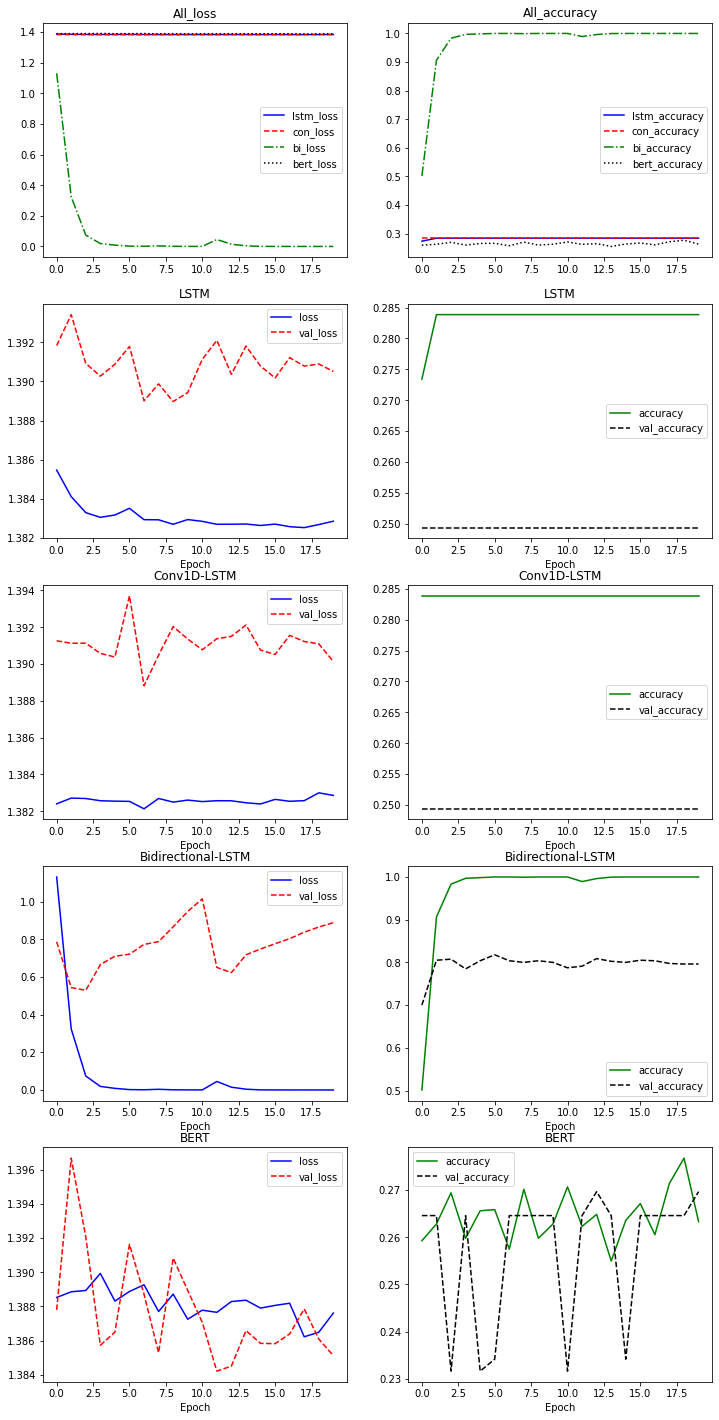

In [30]:
import matplotlib.pyplot as plt
# 학습 결과 시각화

num_model = 4
plt_size = num_model + 1

plt.figure(figsize=(12, 5 * plt_size))

plt.subplot(plt_size, 2, 1)
plt.plot(history.history['loss'], 'b-', label='lstm_loss')
plt.plot(con_history.history['loss'], 'r--', label='con_loss')
plt.plot(model_bi_history.history['loss'], 'g-.', label='bi_loss')
plt.plot(history_bert.history['loss'], 'k:', label='bert_loss')
plt.plot()
plt.title('All_loss')
plt.legend()

plt.subplot(plt_size, 2, 2)
plt.plot(history.history['accuracy'], 'b-', label='lstm_accuracy')
plt.plot(con_history.history['accuracy'], 'r--', label='con_accuracy')
plt.plot(model_bi_history.history['accuracy'], 'g-.', label='bi_accuracy')
plt.plot(history_bert.history['accuracy'], 'k:', label='bert_accuracy')
plt.title('All_accuracy')
plt.legend()

plt.subplot(plt_size, 2, 3)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.title('LSTM')
plt.legend()

plt.subplot(plt_size, 2, 4)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.title('LSTM')
plt.legend()

plt.subplot(plt_size, 2, 5)
plt.plot(con_history.history['loss'], 'b-', label='loss')
plt.plot(con_history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.title('Conv1D-LSTM')
plt.legend()

plt.subplot(plt_size, 2, 6)
plt.plot(con_history.history['accuracy'], 'g-', label='accuracy')
plt.plot(con_history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.title('Conv1D-LSTM')
plt.legend()

plt.subplot(plt_size, 2, 7)
plt.plot(model_bi_history.history['loss'], 'b-', label='loss')
plt.plot(model_bi_history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.title('Bidirectional-LSTM')
plt.legend()

plt.subplot(plt_size, 2, 8)
plt.plot(model_bi_history.history['accuracy'], 'g-', label='accuracy')
plt.plot(model_bi_history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.title('Bidirectional-LSTM')
plt.legend()

plt.subplot(plt_size, 2, 9)
plt.plot(history_bert.history['loss'], 'b-', label='loss')
plt.plot(history_bert.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.title('BERT')
plt.legend()

plt.subplot(plt_size, 2, 10)
plt.plot(history_bert.history['accuracy'], 'g-', label='accuracy')
plt.plot(history_bert.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.title('BERT')
plt.legend()

plt.show()

In [43]:
import json

# 테스트 데이터 로드
test_file_path = 'data/mnt/test.json'
with open(test_file_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# submission 파일 로드
submission_file_path = 'data/mnt/submission.csv'
submission = pd.read_csv(submission_file_path)

# JSON 파일의 인덱스 추출 및 정렬
json_indices = list(test_data.keys())
json_indices.sort()  # 정렬

# submission 파일의 인덱스 추출
submission_indices = submission['file_name'].tolist()

# JSON 파일에서 텍스트 데이터 추출
test_texts = [test_data[idx]['text'] for idx in submission_indices]

# 텍스트 정제
test_texts_cleaned = [clean_text(text) for text in test_texts]

# Keras Tokenizer 설정
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_conversation'])  # train_data는 미리 로드된 학습 데이터셋이어야 합니다.

# 입력 데이터 인코딩 및 패딩
test_sequences = tokenizer.texts_to_sequences(test_texts_cleaned)
max_length = 300
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [44]:
# 모델을 사용하여 예측 수행
test_predictions = model_bi.predict(test_padded_sequences)

# 예측된 클래스 인덱스
predicted_classes = np.argmax(test_predictions, axis=1)

# 예측된 클래스 레이블로 변환
label_encoder = LabelEncoder()
label_encoder.fit(train_data['class'])  # train_data는 미리 로드된 학습 데이터셋이어야 합니다.
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# 예측 결과를 submission 파일에 채우기
submission['class'] = predicted_labels

# submission 파일 저장
submission.to_csv('submission_filled.csv', index=False)

print("Submission file has been created.")

Submission file has been created.


In [47]:
import json
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import re

# 테스트 데이터 로드
test_file_path = 'data/mnt/test.json'
with open(test_file_path, 'r', encoding='utf-8') as f:
    test_data = json.load(f)

# submission 파일 로드
submission_file_path = 'data/mnt/submission.csv'
submission = pd.read_csv(submission_file_path)

# JSON 파일의 인덱스 추출 및 정렬
json_indices = list(test_data.keys())
json_indices.sort()  # 정렬

# submission 파일의 인덱스 추출
submission_indices = submission['file_name'].tolist()

# JSON 파일에서 텍스트 데이터 추출
test_texts = [test_data[idx]['text'] for idx in submission_indices]

# 텍스트 정제
test_texts_cleaned = [clean_text(text) for text in test_texts]

# DistilBERT 모델과 토크나이저 설정
distilbert_model_name = 'distilbert-base-multilingual-cased'
tokenizer_dis = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = TFDistilBertModel.from_pretrained(distilbert_model_name)

# 입력 데이터 인코딩 및 패딩
max_length = 128
test_inputs = tokenizer_dis(test_texts_cleaned, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf')

# DistilBERT 모델을 사용하여 임베딩 추출
distilbert_output = distilbert_model(test_inputs['input_ids'], attention_mask=test_inputs['attention_mask'])[0]
distilbert_embeddings = distilbert_output[:, 0, :].numpy()

# 분류 모델 정의 함수
def create_model(num_classes):
    input_ids_input = Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks_input = Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
    distilbert_output = distilbert_model([input_ids_input, attention_masks_input])[0][:, 0, :]
    output_layer = Dense(num_classes, activation='softmax')(distilbert_output)
    model = Model(inputs=[input_ids_input, attention_masks_input], outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 학습된 모델 로드
num_classes = len(train_data['class'].unique())
model_bert = create_model(num_classes)
model_bert.load_weights('path_to_your_trained_model_weights.h5')  # 가중치 파일 경로를 지정하세요

# 예측 수행
test_predictions = model_bert.predict([test_inputs['input_ids'], test_inputs['attention_mask']])

# 예측된 클래스 인덱스
predicted_classes = np.argmax(test_predictions, axis=1)

# 예측된 클래스 레이블로 변환
label_encoder = LabelEncoder()
label_encoder.fit(train_data['class'])
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# 예측 결과를 submission 파일에 채우기
if len(predicted_labels) == len(submission):
    submission['class'] = predicted_labels
else:
    raise ValueError("The length of the predicted labels does not match the length of the submission file.")

# submission 파일 저장
submission.to_csv('submission_filled.csv', index=False)

print("Submission file has been created.")

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


OSError: Unable to open file (unable to open file: name = 'path_to_your_trained_model_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)